<a href="https://colab.research.google.com/github/ConSurv/HABP/blob/master/ConvDenoisingEncoder/DenoisingAutoEncoder_keras_SMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
print(GPUs)
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [0]:
! pip install keras_layer_normalization

# **IMPORTING SMIC DATASETS**

In [0]:
!wget -O SMIC_all_raw.7z http://www.ee.oulu.fi/~lxiaobai/SMIC_all_raw.7z

In [0]:
!7z x SMIC_all_raw.7z -poulusmicallraw

In [0]:
import keras
import cv2
import numpy as np
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D , MaxPooling2D,UpSampling2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
class Config:
    DATASET_PATH = "/content/SMIC_all_raw/HS".replace('\\', '/')
    SINGLE_TEST_PATH = "/content/SMIC_all_raw/NIR".replace('\\', '/')
    BATCH_SIZE = 6
    EPOCHS = 10
    MODEL_PATH = "/content/drive/My Drive/FYP_MODEL/SMIC_model.hdf5".replace('\\', '/')
    noise_factor = 0.5


In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    # print(len(clips))
    # print(np.array(clips).shape)
    return clips


In [0]:
def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    noise_clips = []
    labels = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        # print(f)
        if isdir(join(Config.DATASET_PATH, f)):
            path = join(Config.DATASET_PATH,f)
            for c in sorted(listdir(path)):
              if c == "micro":
                path = join(path,c)
                for category in sorted(listdir(path)):
                  label = category
                  path1 = join(path,category)
                  for videoclip in sorted(listdir(path1)):
                    videoPath = join(path1,videoclip)
                    all_frames = []
                    noise_all_frames = []
                    # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
                    for frame in sorted(listdir(videoPath)):
                      if str(join(videoPath,frame))[-3:] == "bmp":
                        imagepath = join(videoPath,frame)
                        image = cv2.imread(imagepath)
                        imageresize = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
                        img = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                        img1 = np.array(img, dtype=np.float32)/256.0
                        noise_img = img1 + Config.noise_factor + np.random.rand(256,256)
                        all_frames.append(img1)
                        noise_all_frames.append(noise_img) 
                
                    # get the 10-frames sequences from the list of images after applying data augmentation
                    for stride in range(1, 2):
                      frames = get_clips_by_stride(stride=1, frames_list=all_frames, sequence_size=10)
                      noise_frames = get_clips_by_stride(stride=1, frames_list=noise_all_frames, sequence_size=10)
                      clips.extend(frames)
                      noise_clips.extend(noise_frames) 
                    for i in range(0,len(frames)):
                      labels.append(label)

    return clips,noise_clips,labels


In [0]:
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH, custom_objects={'LayerNormalization': LayerNormalization})
   
    seq = Sequential()
    print("Model initialized")

    #################Encoder###############
    seq.add(
        TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(MaxPooling2D()))

    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(MaxPooling2D()))
     
    # # # # #
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # Code
    seq.add(ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    ###########DECODER###############
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(UpSampling2D()))

    seq.add(TimeDistributed(Conv2DTranspose(64, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(UpSampling2D()))

    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    
    return seq


In [0]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
def evaluate(train_set, noise_train_set, validation_set, noise_validation_set):
    model = get_model(True)
    print("got model")

    # fit the model
    hist = model.fit(noise_train_set, train_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False,
            validation_data=(noise_validation_set, validation_set))
    model.save(Config.MODEL_PATH)
    return hist

In [0]:
# get training data
print("Fetching dataset.........")
train_set, noise_train_set, labels = get_training_set()
train_set = np.array(train_set)
noise_train_set = np.array(noise_train_set)
print("Completed Fetching!!!")
train_labels = np.zeros(len(labels))
# print(labels)
for i in range(len(labels)):
  if labels[i]=="positive":
    train_labels[i] = 0
  elif labels[i]=="negative":
    train_labels[i] = 1
  else:
    train_labels[i] = 2
print("labels generated......")

# Save training images and labels in a numpy array
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC_images.npy', train_set)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC_noise_images.npy', noise_train_set)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC_labels.npy', train_labels)

In [0]:
import numpy as np
# Load training images and labels that are stored in numpy array
train_set = np.load('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC_images.npy')
noise_train_set = np.load('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC_noise_images.npy')
train_labels =np.load('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC_labels.npy')

print(train_set.shape)
print(noise_train_set.shape)
print(train_labels.shape)

FileNotFoundError: ignored

In [0]:
from sklearn.model_selection import train_test_split
# spliting testing dataset
train_set, test_set, noise_train_set, noise_test_set, train_labels, test_labels =  train_test_split(train_set, noise_train_set, train_labels, test_size=0.1, random_state=4)
train_set, validation_set, noise_train_set, noise_validation_set, train_labels, validation_labels =  train_test_split(train_set, noise_train_set, train_labels, test_size=0.1, random_state=4)


In [0]:
hist= evaluate(train_set, noise_train_set, validation_set, noise_validation_set)

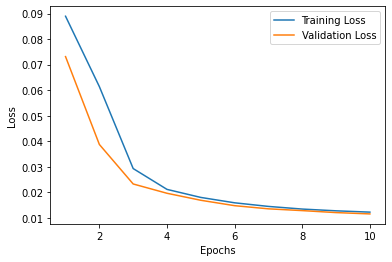

In [0]:
import matplotlib.pyplot as plt

loss_values = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
# modify model upto code layer
model = get_model(False)
modules = model.layers[:-9]
new_model = Sequential(modules)

# extract code features
train_features = new_model.predict(train_set, batch_size = 4)
test_features = new_model.predict(test_set, batch_size = 4)
validation_features = new_model.predict(validation_set, batch_size = 4)

print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)
print(validation_features.shape)
print(validation_labels.shape)

In [0]:
train_features = train_features.reshape(394,10*8*8*16)
test_features = test_features.reshape(49,10*8*8*16)
validation_features = validation_features.reshape(44,10*8*8*16)


print(train_features.shape)
print(test_features.shape)

np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC/train_features.npy', train_features)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC/test_features.npy', test_features)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC/validation_features.npy', validation_features)

np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC/train_labels.npy', train_labels)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC/test_labels.npy', test_labels)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/SMIC/validation_labels.npy', validation_labels)

(394, 10240)
(49, 10240)
